In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
path_modern = "/lus/h2resw01/hpcperm/ccpd/ECE4-DATA/nemo"
path_eocene = "/perm/itas/data/deepMIP/Herold_etal_2014"

In [3]:
topo_eocene = xr.open_dataset(f"{path_eocene}/herold_etal_eocene_topo_1x1.nc")
domain_modern = xr.open_dataset(f"{path_modern}/domain/ORCA1/domain_cfg.nc")
domain_modern = domain_modern.drop_dims('t')

In [4]:
iwm_modern = xr.open_dataset(f"{path_modern}/initial/zdfiwm_forcing_r720x360.nc")
iwm_eocene = xr.open_dataset(f"{path_eocene}/Green_Huber_eocene_tidal_dissipation_1x1.nc")

In [8]:
iwm_eocene_remap = xr.open_dataset("/perm/itas/data/nemo/iwm/eocene_tidal_dissipation_r360x180.nc")
iwm_modern_remap = xr.open_dataset("/perm/itas/data/nemo/iwm/zdfiwm_forcing_r360x180.nc")

In [6]:
topo_eocene['bathymetry'] = -topo_eocene['topo'].where(topo_eocene['topo'] < 0)

In [11]:
iwm_eocene_remap['eo_tidal_dissipation']

<xarray.DataArray 'eo_tidal_dissipation' (lat: 180, lon: 360)> Size: 518kB
[64800 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Attributes:
    long_name:  Eocene tidal dissipation
    units:      W/m^2

In [ ]:
iwm_modern_remap['mask'] = iwm_modern_remap['bathymetry'].where(iwm_modern_remap['bathymetry'].isnull(), 1)
comps = ['power_bot', 'power_cri', 'power_nsq', 'power_sho']
iwm_modern_remap['tidal_dissipation'] = (
    iwm_modern_remap['mask'] *
    iwm_modern_remap[comps].to_array().sum("variable")
)

#iwm_modern[''] = iwm_modern['bathymetry'].where(iwm_modern['bathymetry'].isnull(), 1)
#iwm_modern['tidal_dissipation'] = iwm_modern[''] * (iwm_modern['power_bot']+iwm_modern['power_cri']+iwm_modern['power_nsq']+iwm_modern['power_sho'])

iwm_modern['mask'] = iwm_modern['bathymetry'].where(iwm_modern['bathymetry'].isnull(), 1)
comps = ['power_bot', 'power_cri', 'power_nsq', 'power_sho']
iwm_modern['tidal_dissipation'] = (
    iwm_modern['mask'] *
    iwm_modern[comps].to_array().sum("variable")
)

In [34]:
import os
import xarray as xr
from cdo import Cdo

cdo = Cdo()

def make_eocene_tidal_file(herold_folder, output_folder, hcri_value=500.0):

    m2_varname="eo_tidal_dissipation"

    herold_file_orig = os.path.join(herold_folder, "Green_Huber_eocene_tidal_dissipation_1x1.nc")
    herold_file_remap = os.path.join(herold_folder, "Green_Huber_eocene_tidal_dissipation_r720x360.nc")
    zdfiwm_file = os.path.join(output_folder, "zdfiwm_forcing_r720x360.nc")
    output_file = os.path.join(output_folder, "zdfiwm_forcing_r720x360_eocene.nc")

    cdo.remapcon("r720x360", input=herold_file_orig, output=herold_file_remap)

    ds_m2 = xr.open_dataset(herold_file_remap)
    ds_pd = xr.open_dataset(zdfiwm_file)

    m2 = ds_m2[m2_varname]

    # --- deep copy of PD file
    ds_out = ds_pd.copy(deep=True)

    # --- inject M2 into power_cri (1/3 only)
    ds_out['power_cri'][:] = (1.0 / 3.0) * m2.values

    # --- zero other energy reservoirs
    ds_out['power_nsq'][:] = 0.0
    ds_out['power_sho'][:] = 0.0
    ds_out['power_bot'][:] = 0.0

    # --- vertical length scales
    ds_out['scale_cri'][:] = hcri_value
    ds_out['scale_bot'][:] = 0.0   # unused if power_bot = 0

    # --- write file
    ds_out.to_netcdf(output_file)

    print(f"Written NEMO 4.2 tidal file: {output_file}")


In [35]:
make_eocene_tidal_file(
    herold_folder="/perm/itas/data/deepMIP/Herold_etal_2014", 
    output_folder="/ec/res4/hpcperm/itas/data/ece-4-database/nemo/initial", 
    hcri_value=500.0
)

Written NEMO 4.2 tidal file: /ec/res4/hpcperm/itas/data/ece-4-database/nemo/initial/zdfiwm_forcing_r720x360_eocene.nc


In [29]:
data = xr.open_dataset("/perm/itas/data/nemo/iwm/zdfiwm_forcing_r360x180_eocene.nc")


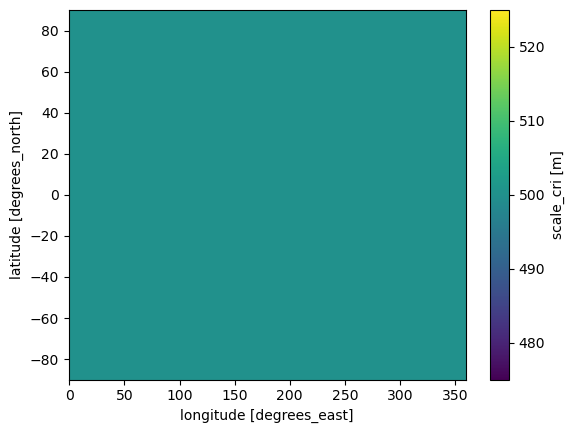

In [32]:
data['scale_cri'].plot()

In [8]:
#plt.hist(topo_eocene['bathymetry'].values.flatten(), density=True, bins=100, histtype="step", label='EOCENE 360x180')
#plt.hist(iwm_modern['bathymetry'].values.flatten(), density=True, bins=100, histtype="step", label='MODERN 720x360')
#plt.yscale('log')
#plt.legend(loc="upper right")
#plt.ylabel('PDF')
#plt.xlabel('bathymetry [m]')

In [9]:
#fig, axes = plt.subplots(1, 2, figsize=(12, 5))
#iwm_eocene['mod_tidal_dissipation'].plot(ax=axes[0], vmin=0.001, vmax=0.01)
#axes[0].set_title("Eocene M2-only dissipation from Green-Huber")
#iwm_modern['tidal_dissipation'].plot(ax=axes[1], vmin=0.001, vmax=0.01)
#axes[1].set_title("Modern total dissipation from ZDFIWM")
#plt.tight_layout()

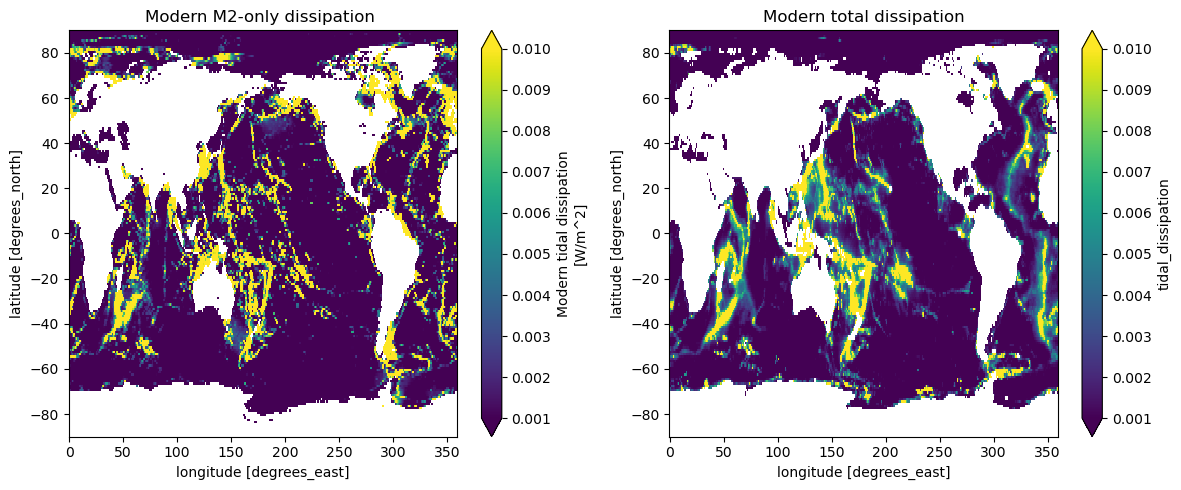

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
iwm_eocene_remap['mod_tidal_dissipation'].plot(ax=axes[0], vmin=0.001, vmax=0.01)
axes[0].set_title("Modern M2-only dissipation ")
iwm_modern_remap['tidal_dissipation'].plot(ax=axes[1], vmin=0.001, vmax=0.01)
axes[1].set_title("Modern total dissipation")
plt.tight_layout()

In [ ]:
#diff = np.abs(iwm_eocene_remap['mod_tidal_dissipation'] - iwm_modern_remap['tidal_dissipation'])
#plt.hist(diff.values.flatten(), density=True, bins=100, histtype="step", label='DIFF')
#plt.yscale('log')
#plt.xscale('log')
#plt.legend(loc="upper right")
#plt.ylabel('PDF')
#plt.xlabel('tidal dissipation difference [W/m^2]')

In [ ]:
#import matplotlib.colors as colors
#diff.plot(norm=colors.LogNorm(vmin=1e-5, vmax=10))

In [12]:
#plt.hist(iwm_eocene['mod_tidal_dissipation'].values.flatten(), density=True, bins=100, histtype="step", range=[0.0, 4.0], label='MODERN Green-Huber')
#plt.hist(iwm_modern['tidal_dissipation'].values.flatten(), density=True, bins=100, histtype="step", range=[0.0, 4.0], label='MODERN ZDFIWM')
#plt.yscale('log')
#plt.legend(loc="upper right")
#plt.ylabel('PDF')
#plt.xlabel('tidal dissipation [W/m^2]')

In [13]:
#plt.hist(iwm_eocene['eo_tidal_dissipation'].values.flatten(), density=True, bins=100, range=[0.0, 4.0], histtype="step", label='EOCENE Green-Huber')
#plt.hist(iwm_eocene['mod_tidal_dissipation'].values.flatten(), density=True, bins=100, range=[0.0, 4.0], histtype="step", label='MODERN Green-Huber')
#plt.yscale('log')
#plt.legend(loc="upper right")
#plt.ylabel('PDF')
#plt.xlabel('tidal dissipation [W/m^2]')

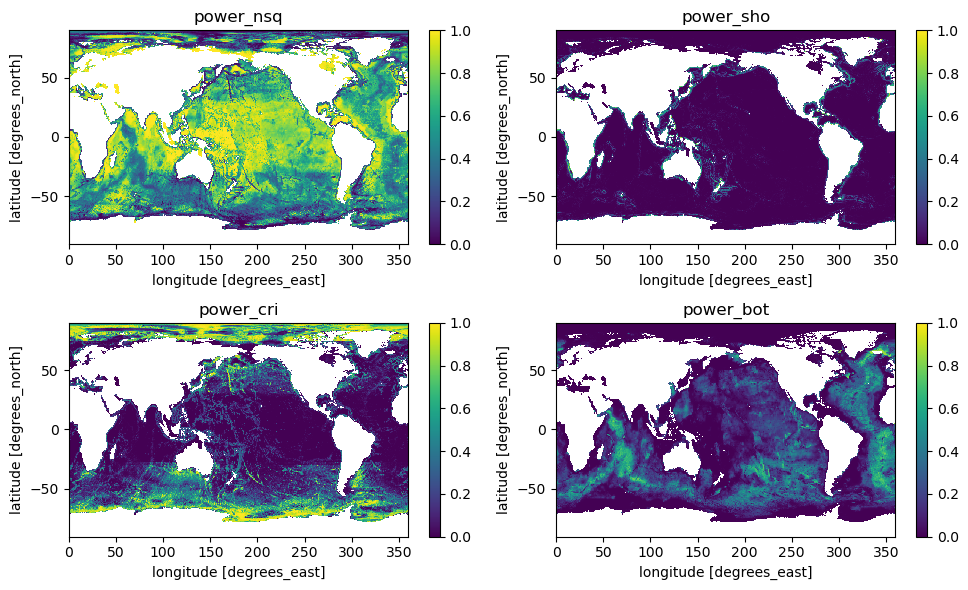

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
(iwm_modern['mask']*iwm_modern['power_nsq']/iwm_modern['tidal_dissipation']).plot(ax=axes[0][0], vmin=0.0, vmax=1.0)
axes[0][0].set_title("power_nsq")
(iwm_modern['mask']*iwm_modern['power_sho']/iwm_modern['tidal_dissipation']).plot(ax=axes[0][1], vmin=0.0, vmax=1.0)
axes[0][1].set_title("power_sho")
(iwm_modern['mask']*iwm_modern['power_cri']/iwm_modern['tidal_dissipation']).plot(ax=axes[1][0], vmin=0.0, vmax=1.0)
axes[1][0].set_title("power_cri")
(iwm_modern['mask']*iwm_modern['power_bot']/iwm_modern['tidal_dissipation']).plot(ax=axes[1][1], vmin=0.0, vmax=1.0)
axes[1][1].set_title("power_bot")
plt.tight_layout()

Text(0, 0.5, 'bot')

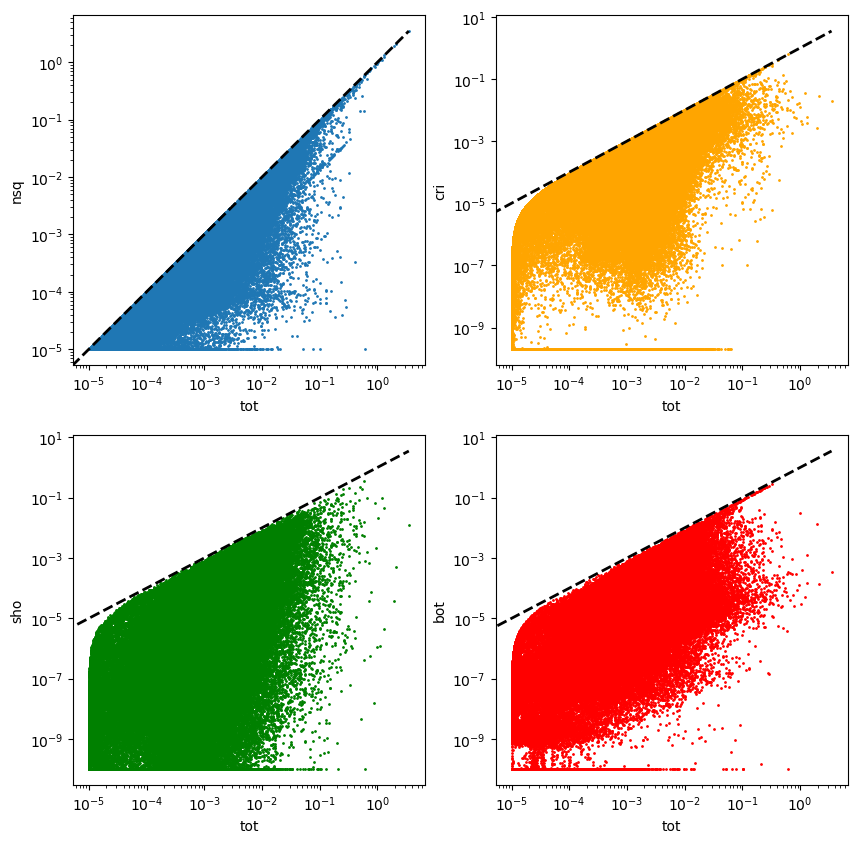

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

x = np.linspace(0, 3.5, 100)
y = x
axes[0][0].plot(x, y, linewidth=2, label="x", ls='--', color='black')
axes[0][0].scatter(iwm_modern['tidal_dissipation'],iwm_modern['power_nsq'], s=1, label='nsq')
axes[0][0].set_yscale('log')
axes[0][0].set_xscale('log')
axes[0][0].set_xlabel('tot')
axes[0][0].set_ylabel('nsq')

axes[1][0].plot(x, y, linewidth=2, label="x", ls='--', color='black')
axes[1][0].scatter(iwm_modern['tidal_dissipation'],iwm_modern['power_sho'], label='sho', s=1, color='green')
axes[1][0].set_yscale('log')
axes[1][0].set_xscale('log')
axes[1][0].set_xlabel('tot')
axes[1][0].set_ylabel('sho')

axes[0][1].plot(x, y, linewidth=2, label="x", ls='--', color='black')
axes[0][1].scatter(iwm_modern['tidal_dissipation'],iwm_modern['power_cri'], label='cri', s=1, color='orange')
axes[0][1].set_yscale('log')
axes[0][1].set_xscale('log')
axes[0][1].set_xlabel('tot')
axes[0][1].set_ylabel('cri')

axes[1][1].plot(x, y, linewidth=2, label="x", ls='--', color='black')
axes[1][1].scatter(iwm_modern['tidal_dissipation'],iwm_modern['power_bot'], label='bot', s=1, color='red')
axes[1][1].set_yscale('log')
axes[1][1].set_xscale('log')
axes[1][1].set_xlabel('tot')
axes[1][1].set_ylabel('bot')


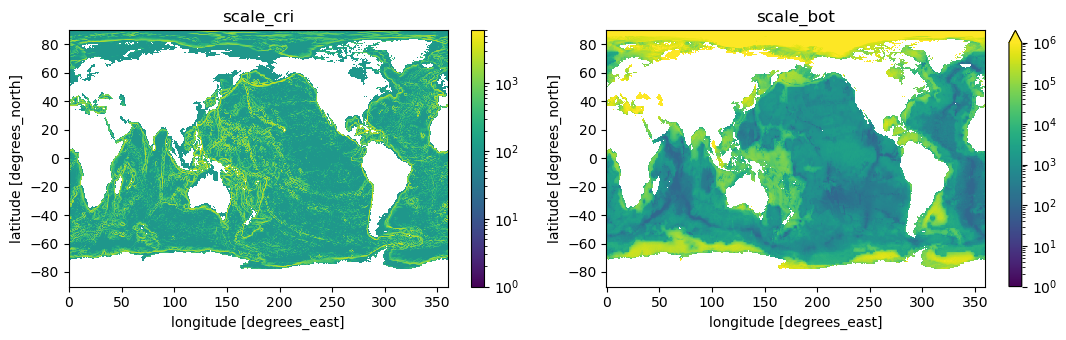

In [13]:
import matplotlib.colors as colors

fig, axes = plt.subplots(1, 2, figsize=(11, 3.5))
(iwm_modern['mask'] * iwm_modern['scale_cri']).plot(ax=axes[0], norm=colors.LogNorm(vmin=1, vmax=6000))
axes[0].set_title("scale_cri")
(iwm_modern['mask'] * iwm_modern['scale_bot']).plot(ax=axes[1], norm=colors.LogNorm(vmin=1, vmax=1e6))
axes[1].set_title("scale_bot")
plt.tight_layout()

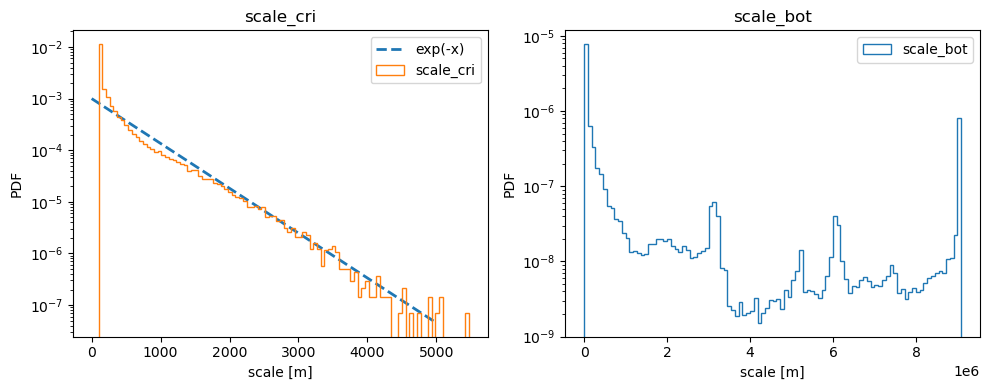

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

x = np.linspace(0, 5000, 100)
y = 0.001*np.exp(-x/500)
axes[0].plot(x, y, linewidth=2, label="exp(-x)", ls='--')
axes[0].hist(iwm_modern['scale_cri'].values.flatten(), density=True, bins=100, histtype="step", label='scale_cri')
#axes[0].hist(iwm_modern['bathymetry'].values.flatten(), density=True, bins=100, histtype="step", label='modern bathymetry')
#axes[0].hist(topo_eocene['bathymetry'].values.flatten(), density=True, bins=100, histtype="step", label='eocene bathymetry')
axes[0].set_title("scale_cri")
axes[0].set_yscale('log')
axes[0].set_ylabel('PDF')
axes[0].set_xlabel('scale [m]')
axes[0].legend(loc="upper right")

axes[1].hist(iwm_modern['scale_bot'].values.flatten(), density=True, bins=100, histtype="step", label='scale_bot')
axes[1].set_title("scale_bot")
axes[1].set_yscale('log')
axes[1].set_ylabel('PDF')
axes[1].set_xlabel('scale [m]')
axes[1].legend(loc="upper right")

plt.tight_layout()


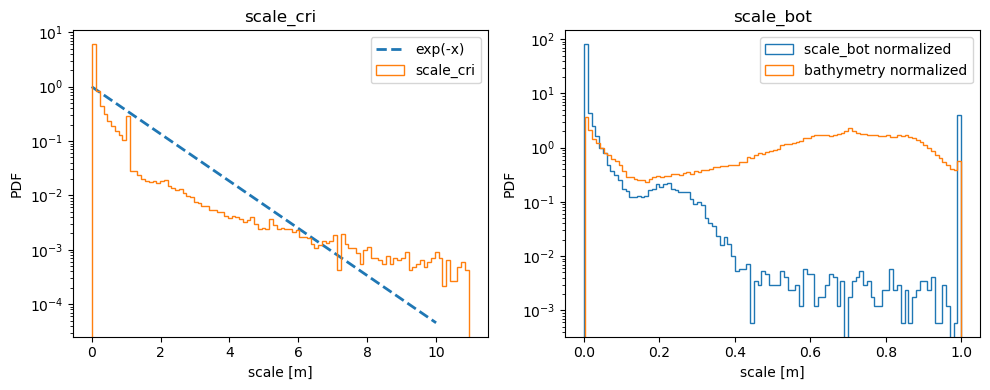

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

x = np.linspace(0, 10, 100)
y = np.exp(-x)
axes[0].plot(x, y, linewidth=2, label="exp(-x)", ls='--')
ratio1 = iwm_modern['mask'] * (iwm_modern['scale_cri']/iwm_modern['scale_cri'].max())/(iwm_modern['bathymetry']/iwm_modern['bathymetry'].max())
axes[0].hist(ratio1.values.flatten(), density=True, bins=100, histtype="step", label='scale_cri')
axes[0].set_title("scale_cri")
axes[0].set_yscale('log')
axes[0].set_ylabel('PDF')
axes[0].set_xlabel('scale [m]')
axes[0].legend(loc="upper right")

ratio2 = iwm_modern['mask'] * (iwm_modern['scale_bot']/iwm_modern['scale_bot'].max())
ratio3 = iwm_modern['mask'] * (iwm_modern['bathymetry']/iwm_modern['bathymetry'].max())
axes[1].hist(ratio2.values.flatten(), density=True, bins=100, histtype="step", label='scale_bot normalized')
axes[1].hist(ratio3.values.flatten(), density=True, bins=100, histtype="step", label='bathymetry normalized')
axes[1].set_title("scale_bot")
axes[1].set_yscale('log')
axes[1].set_ylabel('PDF')
axes[1].set_xlabel('scale [m]')
axes[1].legend(loc="upper right")

plt.tight_layout()

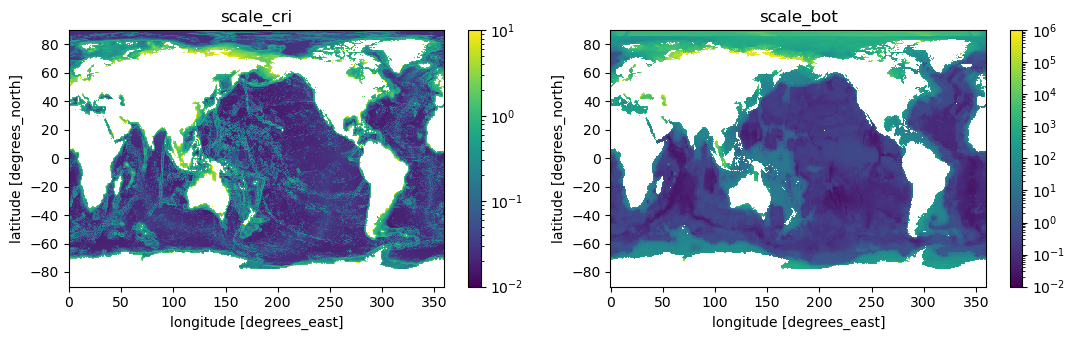

In [16]:
import matplotlib.colors as colors

fig, axes = plt.subplots(1, 2, figsize=(11, 3.5))
(iwm_modern['mask'] * iwm_modern['scale_cri']/iwm_modern['bathymetry']).plot(ax=axes[0], norm=colors.LogNorm(vmin=1e-2, vmax=10))
axes[0].set_title("scale_cri")
(iwm_modern['mask'] * iwm_modern['scale_bot']/iwm_modern['bathymetry']).plot(ax=axes[1], norm=colors.LogNorm(vmin=1e-2, vmax=1e6))
axes[1].set_title("scale_bot")
plt.tight_layout()

In [17]:
# mean values

lat = iwm_modern['tidal_dissipation'].latitude
weights = np.cos(np.deg2rad(lat))

p_tot_mean = iwm_modern['tidal_dissipation'].weighted(weights).mean(dim=("latitude", "longitude")).values
p_nsq_mean = iwm_modern['power_nsq'].weighted(weights).mean(dim=("latitude", "longitude")).values
p_cri_mean = iwm_modern['power_cri'].weighted(weights).mean(dim=("latitude", "longitude")).values
p_bot_mean = iwm_modern['power_bot'].weighted(weights).mean(dim=("latitude", "longitude")).values
p_sho_mean = iwm_modern['power_sho'].weighted(weights).mean(dim=("latitude", "longitude")).values

p_nsq_mean/p_tot_mean,p_cri_mean/p_tot_mean,p_bot_mean/p_tot_mean,p_sho_mean/p_tot_mean

(np.float64(0.5210495907964652),
 np.float64(0.14631786602093086),
 np.float64(0.08756455140338161),
 np.float64(0.09814135993233622))

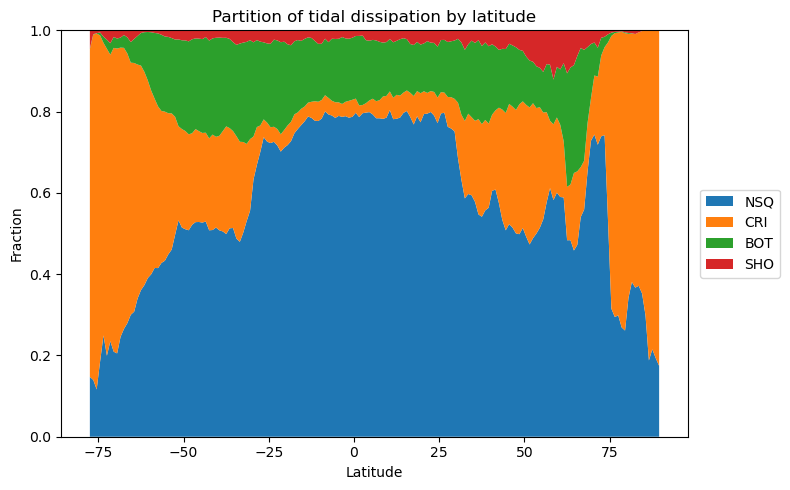

In [18]:
# zonal mean / stacked histogram

lat = iwm_modern_remap.lat

p_nsq_lat = (iwm_modern_remap['power_nsq']/iwm_modern_remap['tidal_dissipation']).mean(dim=['lon'])
p_cri_lat = (iwm_modern_remap['power_cri']/iwm_modern_remap['tidal_dissipation']).mean(dim=['lon'])
p_sho_lat = (iwm_modern_remap['power_sho']/iwm_modern_remap['tidal_dissipation']).mean(dim=['lon'])
p_bot_lat = (iwm_modern_remap['power_bot']/iwm_modern_remap['tidal_dissipation']).mean(dim=['lon'])

plt.figure(figsize=(8,5))
plt.stackplot(
    lat,
    p_nsq_lat,
    p_cri_lat,
    p_bot_lat,
    p_sho_lat,
    labels=["NSQ", "CRI", "BOT", "SHO"]
)

plt.ylabel("Fraction")
plt.xlabel("Latitude")
plt.title("Partition of tidal dissipation by latitude")
plt.ylim(0,1)
plt.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),  # x > 1 sposta la leggenda fuori
    borderaxespad=0
)
plt.tight_layout()
plt.show()


In [19]:
# zonal mean / stacked histogram

# lat = iwm_modern.latitude

# #p_tot_lat = iwm_modern['tidal_dissipation'].mean(dim=['longitude'])
# p_nsq_lat = iwm_modern['power_nsq'].mean(dim=['longitude'])
# p_cri_lat = iwm_modern['power_cri'].mean(dim=['longitude'])
# p_sho_lat = iwm_modern['power_sho'].mean(dim=['longitude'])
# p_bot_lat = iwm_modern['power_bot'].mean(dim=['longitude'])
# p_tot_lat = p_nsq_lat + p_cri_lat + p_bot_lat + p_sho_lat

# plt.figure(figsize=(8,5))
# plt.stackplot(
#     lat,
#     p_nsq_lat/p_tot_lat,
#     p_cri_lat/p_tot_lat,
#     p_bot_lat/p_tot_lat,
#     p_sho_lat/p_tot_lat,
#     labels=["NSQ", "CRI", "BOT", "SHO"]
# )

# plt.ylabel("Fraction")
# plt.xlabel("Latitude")
# plt.title("Partition of tidal dissipation by latitude")
# plt.legend(loc='upper right')
# plt.legend(
#     loc="center left",
#     bbox_to_anchor=(1.02, 0.5),  # x > 1 sposta la leggenda fuori
#     borderaxespad=0
# )
# plt.tight_layout()
# plt.show()

In [20]:
# create mask for eocene
topo_eocene_remap = xr.open_dataset("/perm/itas/data/nemo/iwm/herold_etal_eocene_topo_r360x180.nc")
topo_eocene_remap['bathymetry'] = -topo_eocene_remap['topo'].where(topo_eocene_remap['topo'] < 0)
topo_eocene_remap['mask'] = topo_eocene_remap['bathymetry'].where(topo_eocene_remap['bathymetry'].isnull(), 1)

In [21]:
# broadcasted fields
b_nsq = p_nsq_lat.broadcast_like(iwm_modern_remap['tidal_dissipation'])
b_cri = p_cri_lat.broadcast_like(iwm_modern_remap['tidal_dissipation'])
b_sho = p_sho_lat.broadcast_like(iwm_modern_remap['tidal_dissipation'])
b_bot = p_bot_lat.broadcast_like(iwm_modern_remap['tidal_dissipation'])

In [22]:
# create new fields
#iwm_eocene_remap['eo_tidal_dissipation'] = (iwm_eocene_remap['eo_tidal_dissipation'].fillna(0))
iwm_eocene_remap['power_nsq'] = b_nsq*iwm_eocene_remap['eo_tidal_dissipation']
iwm_eocene_remap['power_cri'] = b_cri*iwm_eocene_remap['eo_tidal_dissipation']
iwm_eocene_remap['power_bot'] = b_sho*iwm_eocene_remap['eo_tidal_dissipation']
iwm_eocene_remap['power_sho'] = b_bot*iwm_eocene_remap['eo_tidal_dissipation']

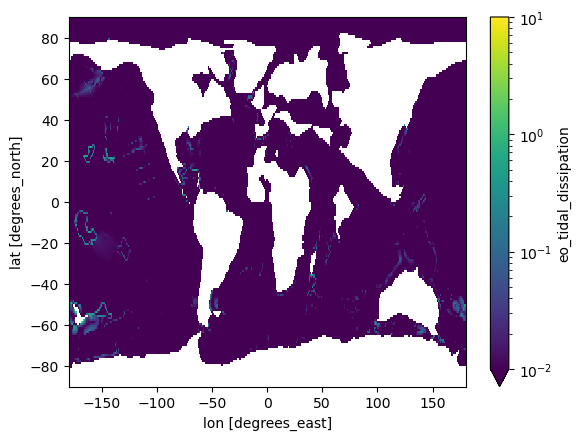

In [28]:
iwm_eocene = xr.open_dataset(f"{path_eocene}/Green_Huber_eocene_tidal_dissipation_1x1.nc")
iwm_eocene_remap = xr.open_dataset("/perm/itas/data/nemo/iwm/eocene_tidal_dissipation_r360x180.nc")
iwm_eocene['eo_tidal_dissipation'] = (iwm_eocene['eo_tidal_dissipation']+1.e-5)
iwm_eocene['eo_tidal_dissipation'].plot(norm=colors.LogNorm(vmin=0.01,vmax=10))

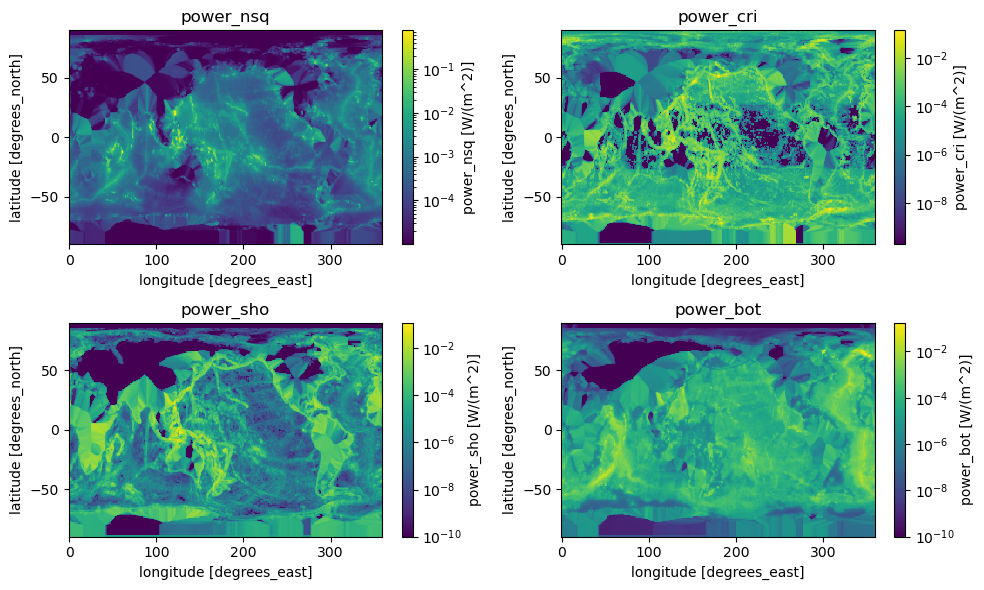

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
iwm_modern_remap['power_nsq'].plot(ax=axes[0][0], norm=colors.LogNorm(vmin=iwm_modern_remap['power_nsq'].min(), vmax=iwm_modern_remap['power_nsq'].max()))
axes[0][0].set_title("power_nsq")
iwm_modern_remap['power_cri'].plot(ax=axes[0][1], norm=colors.LogNorm(vmin=iwm_modern_remap['power_cri'].min(), vmax=iwm_modern_remap['power_cri'].max()))
axes[0][1].set_title("power_cri")
iwm_modern_remap['power_sho'].plot(ax=axes[1][0], norm=colors.LogNorm(vmin=iwm_modern_remap['power_sho'].min(), vmax=iwm_modern_remap['power_sho'].max()))
axes[1][0].set_title("power_sho")
iwm_modern_remap['power_bot'].plot(ax=axes[1][1], norm=colors.LogNorm(vmin=iwm_modern_remap['power_bot'].min(), vmax=iwm_modern_remap['power_bot'].max()))
axes[1][1].set_title("power_bot")
plt.tight_layout()

KeyError: "No variable named 'power_nsq'. Variables on the dataset include ['eo_tidal_dissipation', 'mod_tidal_dissipation', 'lon', 'lat']"

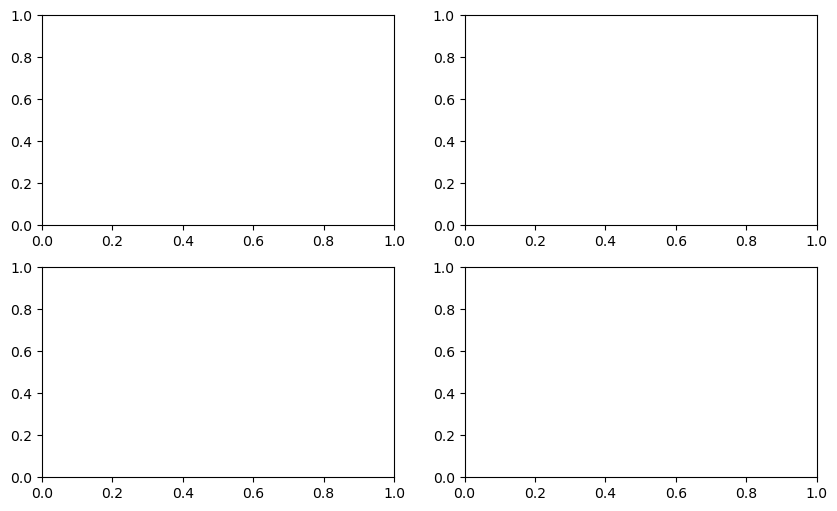

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
iwm_eocene_remap['power_nsq'].plot(ax=axes[0][0], norm=colors.LogNorm(vmin=0.01, vmax=iwm_eocene_remap['power_nsq'].max()))
axes[0][0].set_title("power_nsq")
iwm_eocene_remap['power_cri'].plot(ax=axes[0][1], norm=colors.LogNorm(vmin=0.01, vmax=iwm_eocene_remap['power_cri'].max()))
axes[0][1].set_title("power_cri")
iwm_eocene_remap['power_sho'].plot(ax=axes[1][0], norm=colors.LogNorm(vmin=0.01, vmax=iwm_eocene_remap['power_sho'].max()))
axes[1][0].set_title("power_sho")
iwm_eocene_remap['power_bot'].plot(ax=axes[1][1], norm=colors.LogNorm(vmin=0.01, vmax=iwm_eocene_remap['power_bot'].max()))
axes[1][1].set_title("power_bot")
plt.tight_layout()

In [ ]:
# scatter plot for h_crit vs bathymetry